#### `MSTL` is currently only available on the latest version of statsmodels on GitHub. To use MSTL you need to install the latest version of statsmodels from GitHub

``pip install git+https://github.com/statsmodels/statsmodels.git``

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sktime.utils.plotting import plot_series

from statsmodels.nonparametric._smoothers_lowess import lowess

from statsmodels.tsa.seasonal import MSTL

# Seasonal-Trend decomposition using LOESS for multiple seasonal components (MSTL)

`MSTL` to decompose a time series into a: trend component, multiple season components, and a residual component. MSTL uses STL (Seasonal-Trend decomposition using LOESS) to iteratively extract seasonal components from a time series. 

## How MSTL works

#### If there is no seasonal component
    * Extract the trend using Friedmans super-smoother
    * Substract the trend from the time-series to get residulas
#### If thers is seasonal components
    * Iteratively extact each seasonal component using STL
    * Refine the extracted seasonal component
    * Extract the trend component
    * Extract the residual component

#### STEPS IN MSTL

STEP 1 : **Iteratively extact each seasonal component using STL**

* Iterate through each seasonal component <br>
starting from the shortest period up to the longest period<br>
Eg: daily-seasonality , weekly-seasonality, monthly-seasonality,...

* On each iteration 
    * Extract the seasonal component from the timeseries using STL.
    * Substract the seasonal component from the timeseries
* Continue until all seasonal components are extracted and removed from timeseries

EXAMPLE: Victoria electricity demand dataset - Down-sampled to hourly data

APPLY STL to extract daily seasonal   [ `daily` = `STL(y, period=24)` ]<br>
REMOVE  the daily seasonality from the series   [ `y*` = `y`-`daily` ]<br>
&emsp; &emsp; &emsp; &emsp; &emsp; |<br>
&emsp; &emsp; &emsp; &emsp; &emsp; |<br>
&emsp; &emsp; &emsp; &emsp; &emsp; |<br>

APPLY STL to extract weekly seasonal   [ `weekly` = `STL(y, period=24*7)` ]<br>
REMOVE  the weekly seasonality from the series   [ `y**` = `y*`-`weekly` ]<br>
&emsp; &emsp; &emsp; &emsp; &emsp; |<br>
&emsp; &emsp; &emsp; &emsp; &emsp; |<br>
&emsp; &emsp; &emsp; &emsp; &emsp; |<br>
Continue until all seasonal components are extracted and removed from timeseries


STEP 2 : **Refine the extracted seasonal component**

* Iterate through each of the seasonal component
* On each iteration add back the extacted seasonal component to the de-seasonalized time-series
* Extract the same component back using STL (This process refines the component)
* Substract this extracted new estimate of the seasonal component from the series
* Repeat this for other components

STEP 3 : **Extract the trend component**

* Extract the trend component from the last STL fit; used in STEP 2
* This extracted trend is the MSTL trend

STEP 4 : **Extract the residual component**

* Substract the trend component computed in STEP 3 from the de-seasonalized series


Now we have
* Trend component
* Multiple seasonal component
* Residual component





#### Data Set Synopsis
We will use the Victoria electricity demand dataset found here: 
`https://github.com/tidyverts/tsibbledata/tree/master/data-raw/vic_elec`.

It is the total electricity demand at a half hourly granularity for the state of Victora in Australia from 2002 to the start of 2015.

* We resampled the dataset to hourly


In [54]:
df = pd.read_csv('../../Datasets/victoria_electricity_demand.csv', 
    usecols=['demand', 'date_time'], parse_dates=['date_time'], index_col=['date_time'])

df.head()

,demand
date_time,
2002-01-01 00:00:00,6919.366092
2002-01-01 01:00:00,7165.974188
2002-01-01 02:00:00,6406.542994
2002-01-01 03:00:00,5815.537828
2002-01-01 04:00:00,5497.732922


In [55]:
# plot_series(df);
# plt.xticks(rotation=30);

##### We will filter the data to the same time period as [original MSTL paper [1]](https://arxiv.org/pdf/2107.13462.pdf) which is the first `149` days of the year `2012`.

In [56]:
start = pd.to_datetime('2012-01-01')
end = start + pd.Timedelta(value='149D')
print(f'START DATE : {start} \nEND DATE : {end}')

series = df.loc[start:end,:].copy()

# series.plot(figsize=(15,4))
# plt.xticks(rotation=30);

START DATE : 2012-01-01 00:00:00 
END DATE : 2012-05-29 00:00:00


#### We expect there to be a daily seasonality associated with electricity demand. 

Let’s confirm this by plotting the hourly demand for each day and segregating it by month.

In [57]:
series['month'] = series.index.month
series['day'] = series.index.day
series['hour'] = series.index.hour
series['week'] = series.index.isocalendar().week

## Daily electricity demand in Victoria, Australia by month

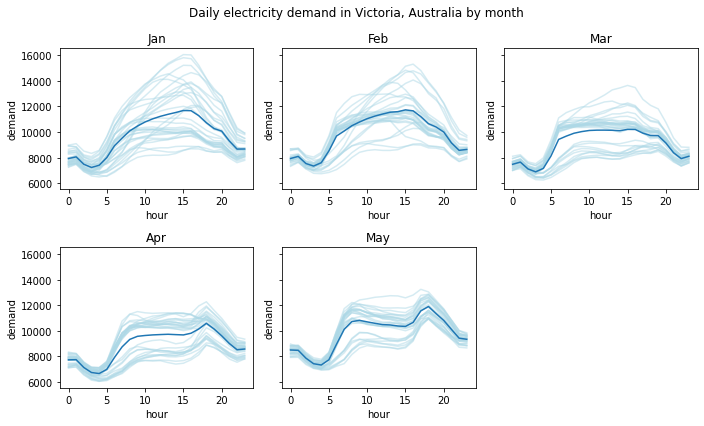

In [58]:
monthDict={1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun',
           7:'Jul', 8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'}

fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(10,6), sharey=True)
frame = ax.ravel()
for k, v in monthDict.items():
    month = series.query(f'month=={k}')
    avg = month.groupby(by='hour').mean()['demand'].values
    f = frame[k-1]
    for d in range(month.index.max().day):
        day = month.loc[month.index.day==d+1]
        demand_on_day = day['demand'].values
        f.plot(demand_on_day, alpha=0.5, c='lightblue')
    f.plot(avg) 
    f.set(title=v, xlabel='hour', ylabel='demand')
    if v=='May':
        break

fig.suptitle("Daily electricity demand in Victoria, Australia by month")
plt.tight_layout()
fig.delaxes(frame[-1])


* We see that there is daily seasonality.

* We can also see the daily seasonality change in time.
    * In the summer months (e.g., January) 
        * there is a daily peak around 4 PM 
    * whereas in the winter months (e.g., May) 
        * there are now two peaks, one around 8 AM and another around 6 PM. 

## Electricity demand in Victoria, Australia by day of week

In [59]:
series.query('week==1').groupby('day').mean()

,demand,month,hour,week
day,,,,
2,10806.233593,1.0,11.5,1.0
3,11095.317224,1.0,11.5,1.0
4,9238.569837,1.0,11.5,1.0
5,8775.874007,1.0,11.5,1.0
6,8757.797148,1.0,11.5,1.0
7,8444.875169,1.0,11.5,1.0
8,8041.288215,1.0,11.5,1.0


In [60]:
series.query('week==2').groupby('day').mean()

,demand,month,hour,week
day,,,,
9,8927.065336,1.0,11.5,2.0
10,8964.897087,1.0,11.5,2.0
11,9053.751316,1.0,11.5,2.0
12,9109.709249,1.0,11.5,2.0
13,8996.868906,1.0,11.5,2.0
14,8091.027802,1.0,11.5,2.0
15,7855.092968,1.0,11.5,2.0


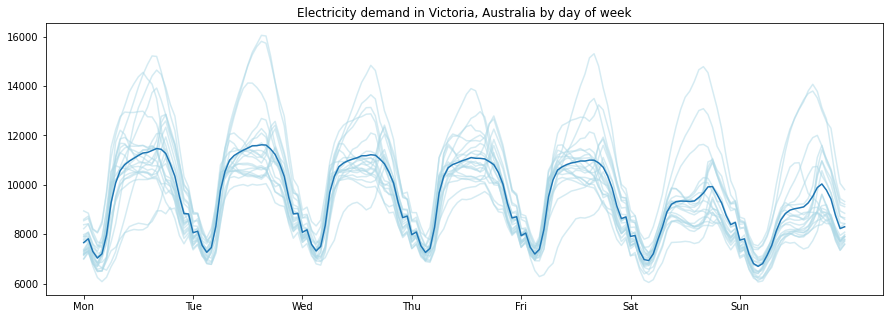

In [61]:
plt.figure(figsize=(15,5))
DAYS = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]

weekly_data=[]
for week, ts in series.groupby('week'):
    ts = ts.reset_index()
    demand = ts['demand']
    plt.plot(demand, alpha=0.5, c='lightblue')
    weekly_data.append(demand)
    
weekly_avg = pd.concat(weekly_data, axis=1).mean(axis=1)
plt.plot(weekly_avg);

plt.title('Electricity demand in Victoria, Australia by day of week')
plt.xticks(ticks=np.arange(0, 167, 24), labels=DAYS)
plt.show()

* We see that there is weekly seasonality 
* There is less demand on weekends than on weekdays.

## Apply MSTL to extract Trend, Multiple Seasonalities & Residuals

The key inputs into `MSTL` are:

* `periods` 
    * The period of each seasonal component 
    * e.g., for hourly data with daily and weekly seasonality we would have: `periods=(24, 24*7)`.
* `windows` 
    * The lengths of each seasonal smoother with respect to each period. 
    * If window size are large then the seasonal component will show less variability over time. 
    * Must be odd. 
    * If `None` a set of default values determined by formula ( 7 + (4*i) ) are selected, where i = 0,1,2,...,period
* `lmbda`
    * The lambda parameter for a Box-Cox transformation prior to decomposition. 
    * If `None` then no transformation is done. 
    * If `"auto"` then an appropriate value for lambda is automatically selected from the data using MLE, Maximum Likelihood Estimates.
* `iterate`
    * Number of iterations to use to refine the seasonal component.
* `stl_kwargs` 
    * All the other parameters which can be passed to STL (e.g., `robust`, `seasonal_deg`, etc.). 


### Note: 

* Missing data must be handled outside of the `MSTL` class.
* The algorithm proposed in the paper handles a case when there is no seasonality. 
* This implementation assumes that there is at least one seasonal component.

In [ ]:
plt.rc('figure',figsize=(15,3))
mstl = MSTL(endog=series['demand'], periods=[24, 24*7], stl_kwargs={"seasonal_deg": 0}).fit()
# mstl.plot();

In [ ]:
# mstl.seasonal['seasonal_168'].plot()

#### Structure left in the residuals
There is still structure left in the residuals. This could be due to any of the following reasons: 

* The MSTL parameters weren't good for this time series, as a result the seasonality has not been extracted perfectly, 
* There are other factors impacting the time series other than trend and seasonality, remember that MSTL assumes we can break the time series up into: trend + seasonal_1 + seasonal_2 + ...., if the underlying data is strongly being influenced by another factor (which may or may not be having an additive or multiplicative impact or perhaps a mix of both!) then the residuals will some structure.




##### Lets Check the daily & monthly seasonality

Let's inspect the seasonal components in a bit more detail and look at the first few days and weeks to examine the daily and weekly seasonality. 



##### One of the advantages of MSTL is that is allows us to capture seasonality which changes over time.
##### We saw above that the daily seasonality is different in the summer and winter. 
##### So let's look at the daily seasonality from MSTL during January and May.

In [ ]:
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(mstl.seasonal[mstl.seasonal.index.month==1]['seasonal_24'].values[:24*3])
plt.title('JAN')
plt.xticks(ticks=np.arange(0,24*3,24), labels=DAYS[:3])
plt.subplot(122)
plt.plot(mstl.seasonal[mstl.seasonal.index.month==5]['seasonal_24'].values[:24*3])
plt.title('MAY')
plt.xticks(ticks=np.arange(0,24*3,24), labels=DAYS[:3])
plt.show()

#### We can see that the daily seasonality of electricity demand is well captured by MSTL. 

#### We see a single peak in January and two peaks in May.

In [ ]:
plt.figure(figsize=(15, 6))

weekly_season_jan = mstl.seasonal[mstl.seasonal.index.month==1]['seasonal_168'].values

idx = np.arange(0,len(weekly_season_jan),24)
days = np.array(['sun', 'mon', 'tue', 'wed', 'thr', 'fri', 'sat'])
label_id = (idx / 24)% 7
labels = days[label_id.astype(int)]
plt.plot(weekly_season_jan)
plt.xticks(ticks=idx, labels=labels, rotation=90);  

sat_start_id = idx[[i==6 for i in label_id]]
mon_start_id = idx[[i==1 for i in label_id]][1:]

for start, end in zip(sat_start_id, mon_start_id):
    plt.axvspan(xmin=start,xmax=end, alpha=0.5, color='salmon')

plt.title('Weekly seasonal component extracted using MSTL : January 2012 Victoria Australia')
plt.show()


#### For the weekly seasonality extracted by MSTL we can see that there is less usage during the weekends as expected. That pattern is stable over the year and we see it in both January and May.

In [ ]:
plt.figure(figsize=(15, 6))

weekly_season_jan = mstl.seasonal[mstl.seasonal.index.month==5]['seasonal_168'].values

idx = np.arange(0,len(weekly_season_jan),24)
days = np.array(['tue', 'wed', 'thr', 'fri', 'sat','sun', 'mon'])
label_id = (idx / 24)% 7
labels = days[label_id.astype(int)]
plt.plot(weekly_season_jan)
plt.xticks(ticks=idx, labels=labels, rotation=90);  

sat_start_id = idx[[i==4 for i in label_id]]
mon_start_id = idx[[i==6 for i in label_id]]

for start, end in zip(sat_start_id, mon_start_id):
    plt.axvspan(xmin=start,xmax=end, alpha=0.5, color='salmon')



plt.title('Weekly seasonal component extracted using MSTL : May 2012 Victoria Australia')
plt.show()

<br>
<img src='./MSTL.PNG' style='transform:rotate(-90deg)'>
<br>


#### We can experiment with different parameters

In [ ]:
# plt.rc('figure',figsize=(15,10))
# mstl = MSTL(endog=series['demand'], periods=[12, 24, 24*7]).fit()
# mstl.plot();

In [ ]:
# plt.rc('figure',figsize=(15,12))
# mstl = MSTL(endog=series['demand'], periods=[6, 12, 24, 24*7]).fit()
# mstl.plot();

In [ ]:
# plt.rc('figure',figsize=(15,14))
# mstl = MSTL(endog=series['demand'], periods=[6, 12, 24, 24*7], windows=[7,13,25,169],stl_kwargs={"seasonal_deg": 0}).fit()
# mstl.plot();